<a href="https://colab.research.google.com/github/Tretlaw/Machine-Learning-/blob/main/Video_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.10.0
!pip install remotezip tqdm opencv-python einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 34.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.13.1
    Uninstalling keras-2.13.1:
      Successfully uninstalled keras-2.13.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.13.0
    Uninstalling tensorflow-estimator-2.13.0:
      Successfully uninstalled tensorflow-estimator-2.13.0

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.8 MB/s eta 0:00:00
  Created wheel for remotezip: filename=remotezip-0.12.1-py3-none-any.whl size=7934 sha256=7c5f9b90fac44ff184e0f1f1d77d8c9220200737018d796e09fdd51170e11a09
  Stored in directory: /root/.cache/pip/wheels/fc/76/04/beed1a6df4eb7430ee13c3900746edd517e5e597298d1f73f3
Successfully built remotezip


In [2]:
import numpy as np
import tqdm
import random
import tensorflow as tf
import collections
import pathlib
import itertools
import cv2
import einops
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from keras import layers

In [1]:
#@title
def list_files_per_class(zip_url):
  files = []
  with rz.RemoteZip(URL) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

def get_class(fname):

  return fname.split('_')[-3]

def get_files_per_class(files):
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def download_from_zip(zip_url, to_dir, file_names):
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file,)

def split_class_lists(files_for_class, count):
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  files = list_files_per_class(zip_url)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 2:
      files.remove(f)

  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class

  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

def format_frames(frame, output_size):

  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames)
      label = self.class_ids_for_name[name]
      yield video_frames, label


In [4]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'
download_dir = pathlib.Path('./UCF101_subset')
subset_paths = download_ufc_101_subset(URL,
                                       num_classes = 10,
                                       splits = {'train': 30, 'val': 10, 'test': 10},
                                       download_dir = download_dir)


train :


100%|██████████| 300/300 [03:06<00:00,  1.61it/s]


val :


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


test :


100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


In [5]:
n_frames = 10
batch_size = 8

output_signature = (tf.TensorSpec(shape=(None, None, None, 3), dtype=tf.float32),
                    tf.TensorSpec(shape = (), dtype=tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature = output_signature)

train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                          output_signature = output_signature)

val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                          output_signature = output_signature)

test_ds = test_ds.batch(batch_size)

In [6]:
HEIGHT = 224
WIDTH = 224

In [7]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    super().__init__()
    self.seq = keras.Sequential(
        [
            #Spatial Decompostion
            layers.Conv3D(filters = filters,
                          kernel_size = (1, kernel_size[1], kernel_size[2]),
                          padding = padding),

            #temporal Decomposition
            layers.Conv3D(filters = filters,
                          kernel_size = (kernel_size[0], 1, 1),
                          padding = padding),
        ]
    )

  def call(self, x):
    return self.seq(x)

In [8]:
class ResidualMain(keras.layers.Layer):
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(
          filters = filters,
          kernel_size = kernel_size,
          padding = 'same'
        ),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(
          filters = filters,
          kernel_size = kernel_size,
          padding = 'same'
        ),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

In [9]:
class Project(keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)


In [10]:
def add_residual_blocks(input, filters, kernel_size):
  out = ResidualMain(filters, kernel_size)(input)

  res = input

  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

In [11]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()

    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    old_shape = einops.parse_shape(video, 'b t h w c') #batch, time, height, weight, channel
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(images, '(b t) h w c -> b t w h c',
                              t = old_shape['t'])
    return videos

In [12]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape = input_shape[1:])
x = input
x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_blocks(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_blocks(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_blocks(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_blocks(x, 128, (3, 3, 3))

x =  layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

model = keras.Model(input, x)

In [13]:
frames, label = next(iter(train_ds))
model.build(frames)

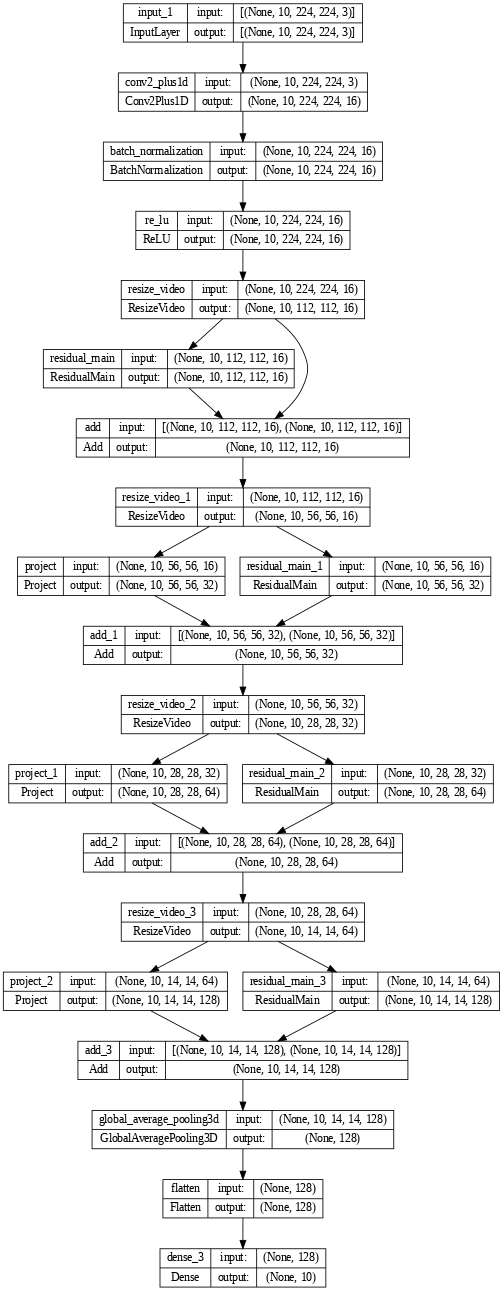

In [14]:
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True) #visualises how the model is processing the data

In [15]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])

In [16]:
history = model.fit(x = train_ds,
                    epochs = 20,
                    validation_data = val_ds)

Epoch 1/20
38/38 [==============================] - 96s 2s/step - loss: 2.5662 - accuracy: 0.1167 - val_loss: 2.7493 - val_accuracy: 0.1000
Epoch 2/20
38/38 [==============================] - 75s 2s/step - loss: 2.2006 - accuracy: 0.2067 - val_loss: 2.2193 - val_accuracy: 0.1200
Epoch 3/20
38/38 [==============================] - 77s 2s/step - loss: 2.0114 - accuracy: 0.2567 - val_loss: 2.4218 - val_accuracy: 0.1900
Epoch 4/20
38/38 [==============================] - 76s 2s/step - loss: 1.8541 - accuracy: 0.3367 - val_loss: 2.3951 - val_accuracy: 0.2100
Epoch 5/20
38/38 [==============================] - 77s 2s/step - loss: 1.8757 - accuracy: 0.3167 - val_loss: 2.9603 - val_accuracy: 0.1900
Epoch 6/20
38/38 [==============================] - 74s 2s/step - loss: 1.8287 - accuracy: 0.3300 - val_loss: 2.2081 - val_accuracy: 0.2200
Epoch 7/20
38/38 [==============================] - 70s 2s/step - loss: 1.6272 - accuracy: 0.3833 - val_loss: 2.2295 - val_accuracy: 0.2300
Epoch 8/20
38/38 [==

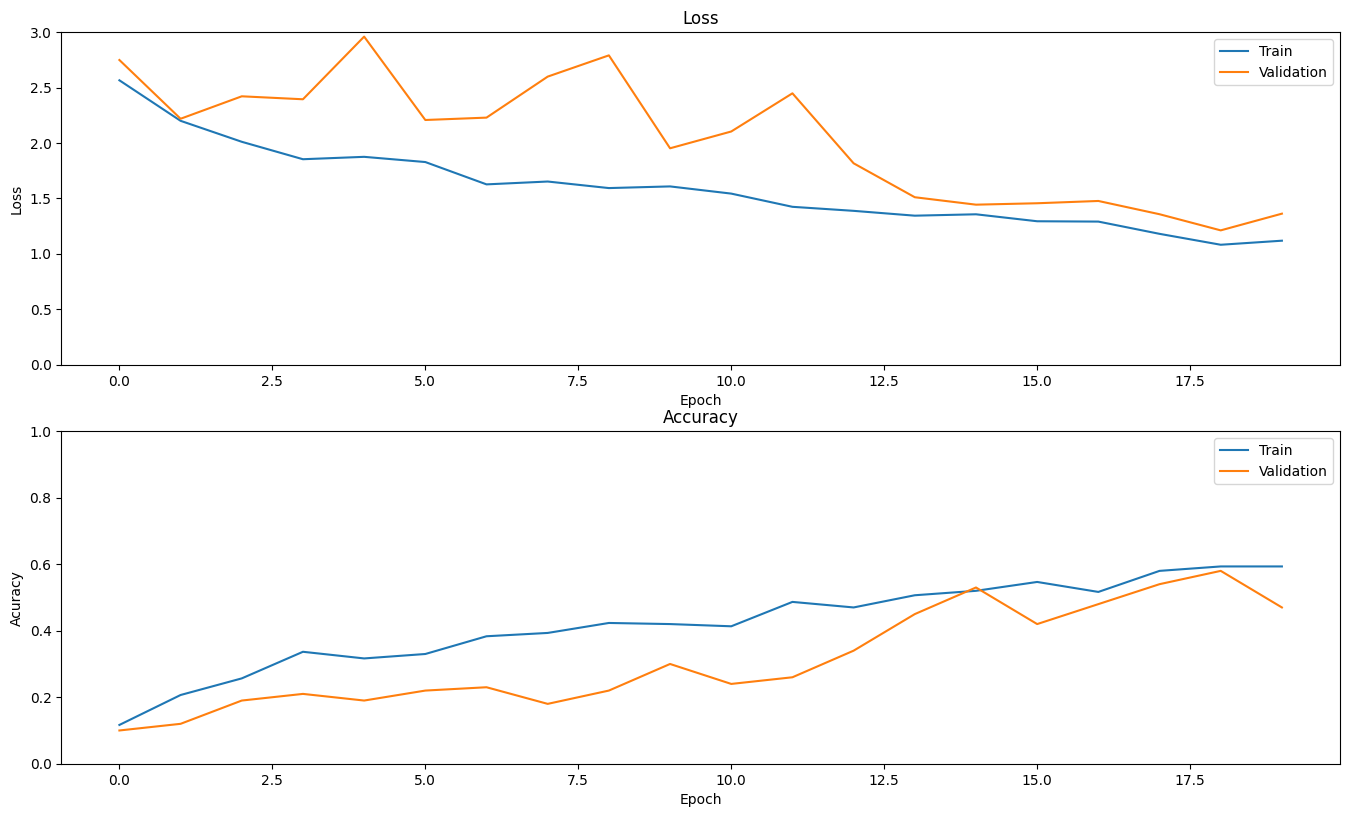

In [20]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(2)
  fig.set_size_inches(16.5, 9.5)

  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label='train')
  ax1.plot(history.history['val_loss'], label='test')
  ax1.set_ylabel('Loss')

  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'])

  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'], label='train')
  ax2.plot(history.history['val_accuracy'], label='test')
  ax2.set_ylabel('Acuracy')

  ax2.set_ylim(0, 1)
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)




In [19]:
model.evaluate(test_ds, return_dict=True)

13/13 [==============================] - 15s 1s/step - loss: 1.3139 - accuracy: 0.4500


{'loss': 1.3139055967330933, 'accuracy': 0.44999998807907104}

In [27]:
def get_actual_predicted_labels(dataset):
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted



In [28]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize': (12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion Matric of Action Recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)


In [29]:
fg = FrameGenerator(subset_paths['train'], n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())

38/38 [==============================] - 42s 1s/step


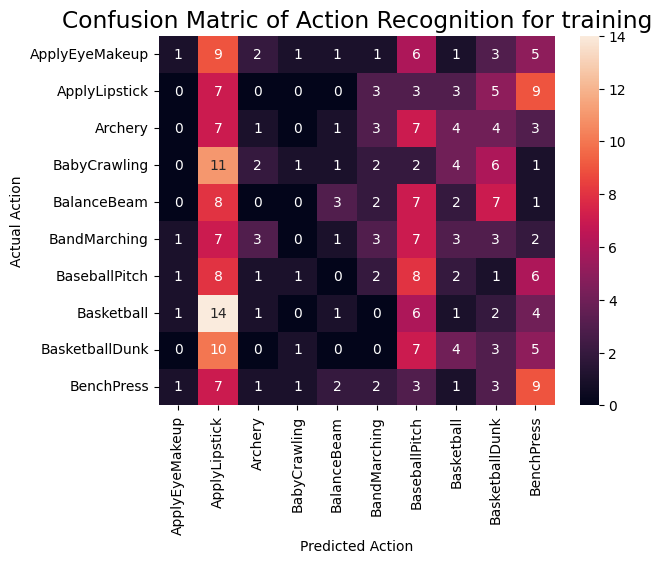

In [30]:
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, 'training')

13/13 [==============================] - 14s 1s/step


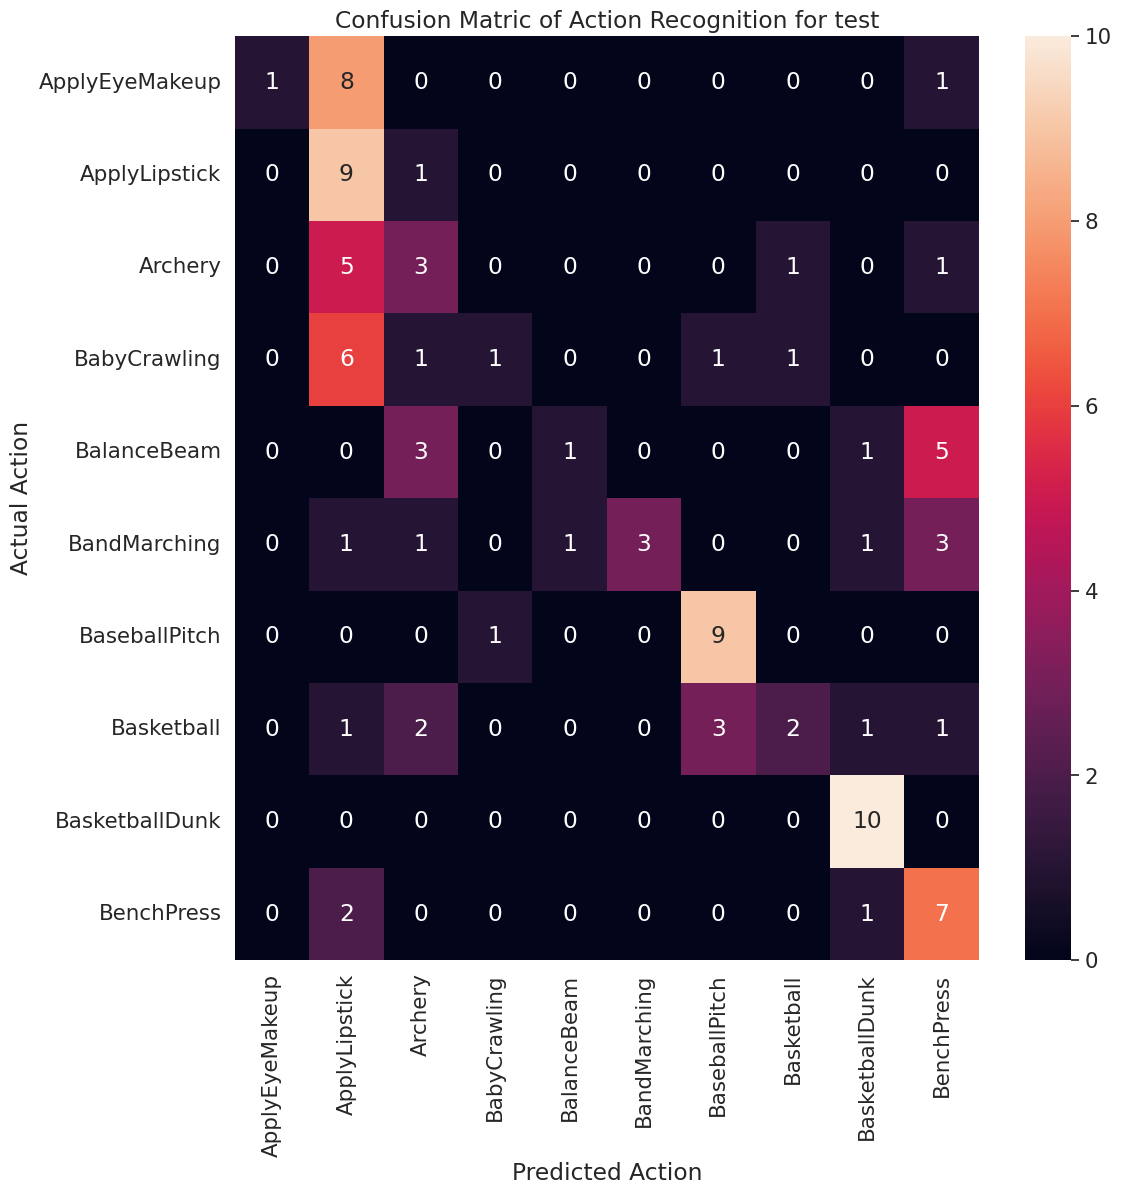

In [32]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

In [33]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm)
  precision = dict()
  recall = dict()

  for i in range(len(labels)):
    col = cm[:i]
    fp = np.sum(col) - tp[i]

    row = cm[i, :]
    fn =  np.sum(row) - tp[i]

    precision[labels[i]] = tp[i] / (tp[i] + fp)
    recall[labels[i]] = tp[i] / (tp[i] + fn)

    return precision, recall



In [37]:
precision, recall = calculate_classification_metrics(actual, predicted, labels)
precision
recall

<ipython-input-33-8b46bac286e9>:14: RuntimeWarning: divide by zero encountered in long_scalars
  precision[labels[i]] = tp[i] / (tp[i] + fp)


{'ApplyEyeMakeup': 0.1}